In [1]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import ArgoTestDataset
from utils import Logger, load_pretrain

torch.cuda.set_device(0)

from lanegcn import get_model
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()


ckpt_path_g = '/data/fyy/new_prediction/argoverse/generator32.000.ckpt'
ckpt_g = torch.load(ckpt_path_g, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt_g["state_dict"])

net.eval()
net.cuda()

dataset = ArgoTestDataset('val', config, train=False)

data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True,
)

preds = {}
gts = {}
cities = {}

for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    out_rel, output = net(data)
    loss_out = loss(output, data)
    break
    
    # with torch.no_grad():
    #     rel, output = net(data)
    # # break
    #     results = [x[0:1].detach().cpu().numpy() for x in output["reg"]]
    # for i, (argo_idx, pred_traj) in enumerate(zip(data["argo_id"], results)):
    #     preds[argo_idx] = pred_traj.squeeze()
    #     cities[argo_idx] = data["city"][i]
    #     gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None
    # if ii == 0:
    #     break

0it [00:01, ?it/s]

[tensor([[[1774.4045,  390.6707],
         [1774.7062,  390.9463],
         [1774.8693,  391.1039],
         [1775.1946,  391.4632],
         [1775.3539,  391.4989],
         [1775.3933,  391.5954],
         [1775.8101,  391.8827],
         [1775.6165,  391.8972],
         [1775.8347,  392.0375],
         [1775.9670,  392.1646],
         [1776.1281,  392.3162],
         [1776.2883,  392.4540],
         [1776.3917,  392.5357],
         [1776.4371,  392.6075],
         [1776.5271,  392.6587],
         [1776.6681,  392.7927],
         [1776.7296,  392.8538],
         [1776.7676,  392.8646],
         [1776.8442,  392.9549],
         [1776.8374,  392.9432],
         [1776.8602,  392.9845],
         [1776.8971,  393.0358],
         [1776.8722,  393.0123],
         [1776.8529,  392.9557],
         [1776.8468,  392.9889],
         [1776.8900,  393.0149],
         [1776.8304,  392.9709],
         [1776.7714,  392.9464],
         [1776.6271,  392.6913],
         [1776.6195,  392.6809]],

       

In [2]:
from vis_utils import ArgoMapVisualizer
map_vis = ArgoMapVisualizer()

In [3]:
m = 4

In [4]:
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon

from argoverse.map_representation.map_api import ArgoverseMap


city_name = data['city'][m]
orig = data['orig'][m]
seq_id = data['argo_id'][m]

rot = data['rot'][m]
trajs_obs = data['trajs2'][m][:,:,:2]
trajs_fut = data['trajs2'][m][:,20:,:2]
traj_pred = output['reg'][m].cpu().detach().numpy()


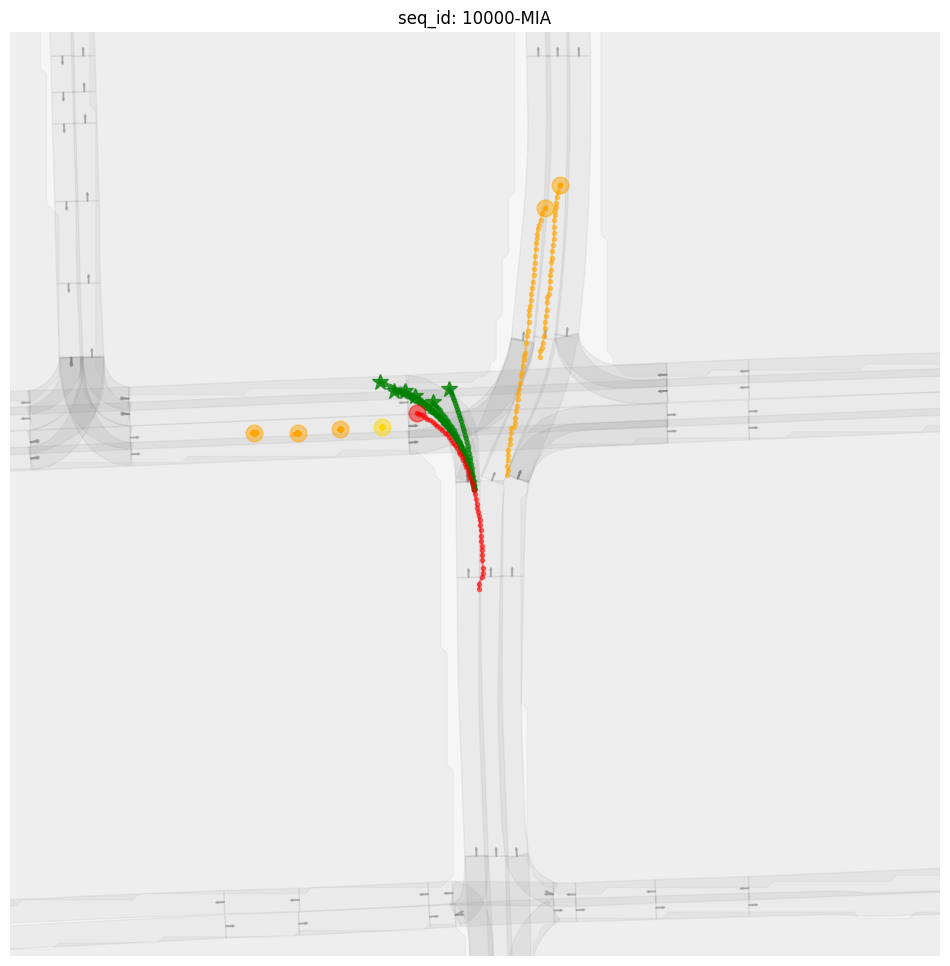

In [5]:
_, ax = plt.subplots(figsize=(12, 12))
ax.axis('equal')
plt.axis('off')
ax.set_title('seq_id: {}-{}'.format(seq_id, city_name))

map_vis.show_surrounding_elements(ax, city_name, orig)

# trajs_obs_1 = np.matmul(rot.T, trajs_obs.T).T + orig
# ax.plot(trajs_obs_1[:,0], trajs_obs_1[:,1], marker='s', color='gold', markersize=8, alpha=0.5)  # plot AV

for i, traj in enumerate(trajs_obs):
    mask = torch.any(traj != 0, dim=1)
    traj = traj[mask]
    traj = np.matmul(rot.T, traj.T).T + orig
    zorder = 10
    if i == 0:
            clr = 'r'
            zorder = 20
    elif i == 1:
            clr = 'gold'
    else:
            clr = 'orange'
    ax.plot(traj[:, 0], traj[:, 1], marker='.', alpha=0.5, color=clr, zorder=zorder)
    ax.plot(traj[-1, 0], traj[-1, 1], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)


for i in range(len(traj_pred[0])):
        # traj = np.matmul((traj_pred[0][i] - orig.numpy()), rot.T)
        traj = traj_pred[0][i]
        ax.plot(traj[:, 0], traj[:, 1], alpha=0.5, color='g', linewidth=3, marker='.', zorder=15)
        ax.plot(traj[-1, 0], traj[-1, 1], marker='*', color='g', markersize=12, alpha=0.75, zorder=30)
# plt.savefig('my_plotb3_4.png', format='png', dpi=300)

In [6]:
trajs_obs.size()

torch.Size([7, 50, 2])